In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [3]:
df = pd.read_csv(csv_path)
# slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

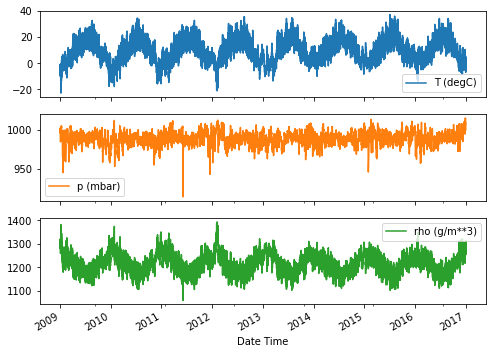

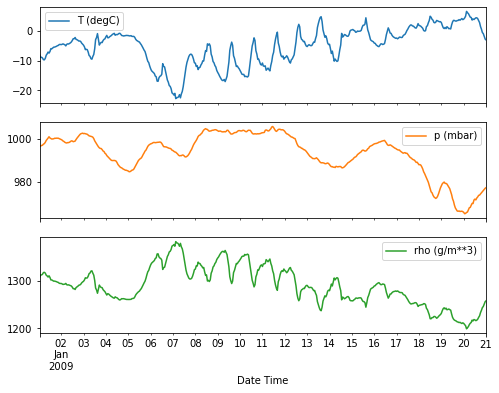

In [4]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


In [6]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame
df['wv (m/s)'].min()

0.0

Text(0, 0.5, 'Wind Velocity [m/s]')

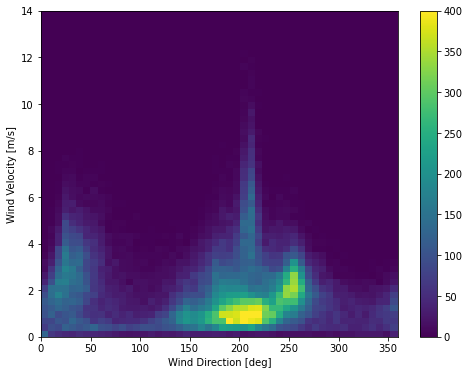

In [7]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

In [8]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

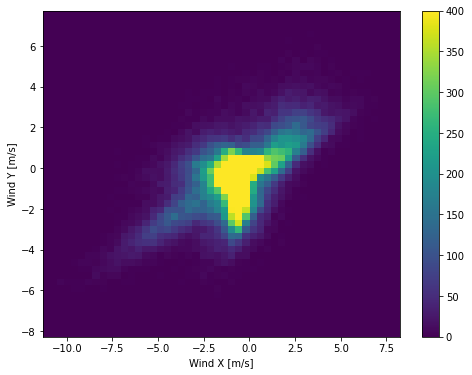

In [9]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

In [10]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

In [11]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

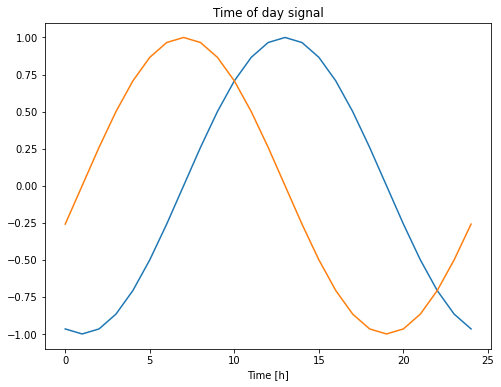

In [12]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

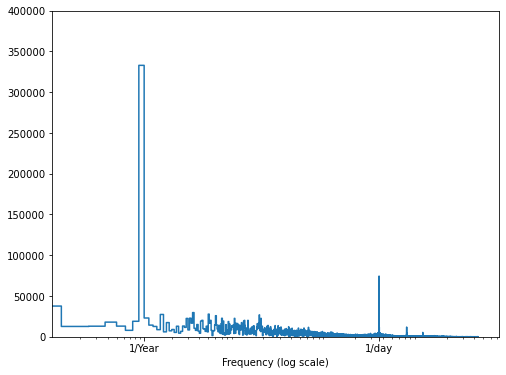

In [13]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [ ]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)